In [2]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=5bbd22f081dcd4c9ef82d8e047413e36b6017968f85475f459f26532f3654d59
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


Junction        int32
Vehicles        int32
ID              int64
hour          float64
day           float64
dayofweek     float64
month         float64
year          float64
is_weekend      int32
dtype: object
Numeric features: ['ID', 'hour', 'day', 'dayofweek', 'month', 'year']
Categorical features: []
Starting RandomForest GridSearchCV
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Starting GradientBoosting GridSearchCV
Fitting 3 folds for each of 4 candidates, totalling 12 fits
RandomForest - Best MSE: 372.7016182836447 Best R2: 0.08549970322193534
GradientBoosting - Best MSE: 371.8643000048264 Best R2: 0.08755423633076198


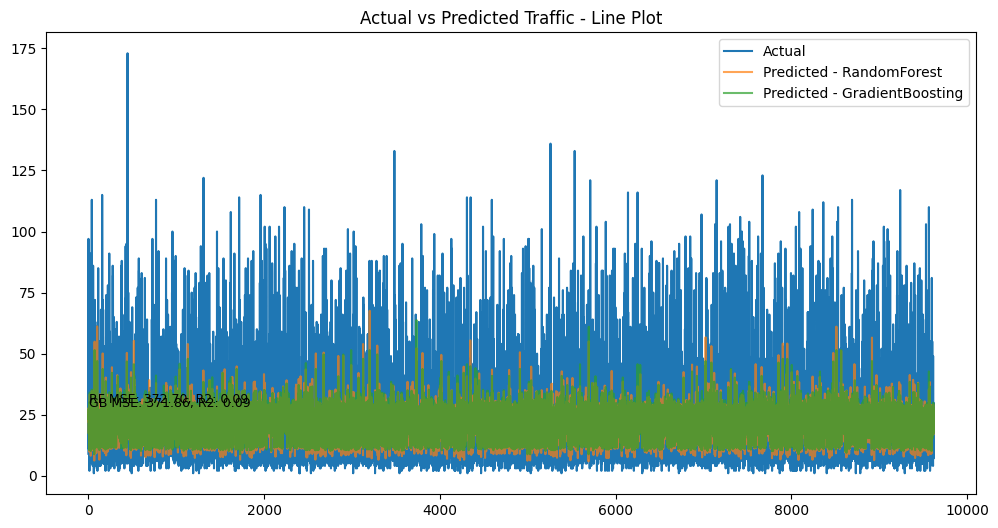

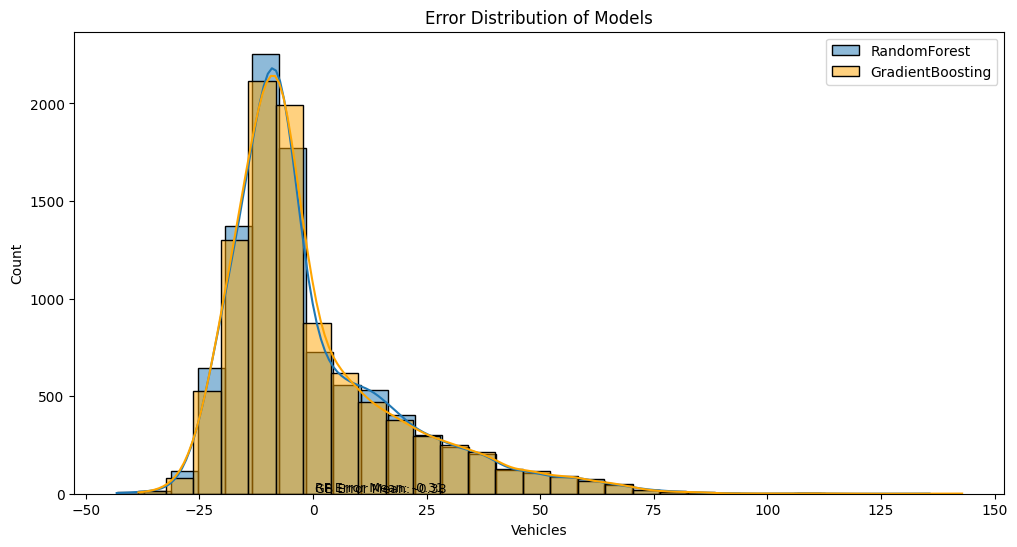

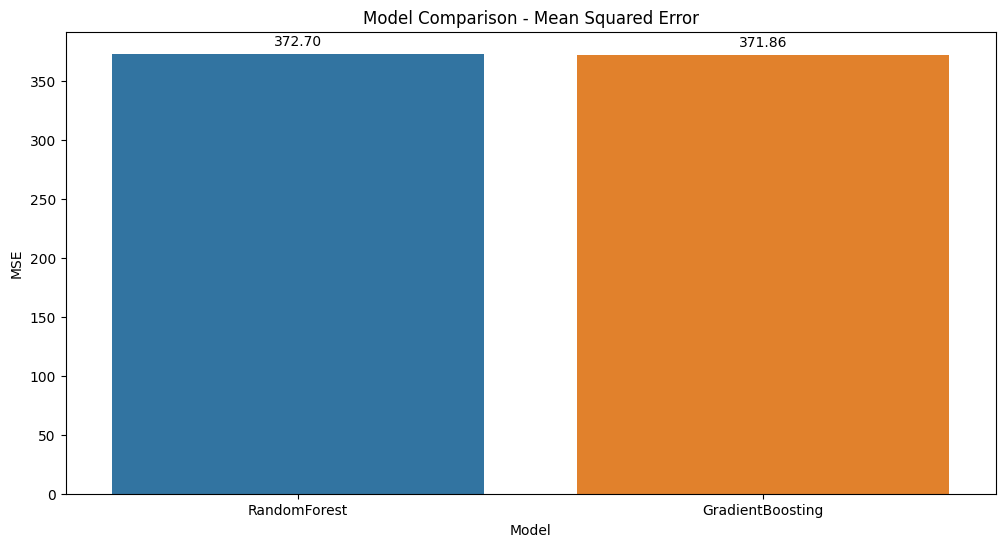

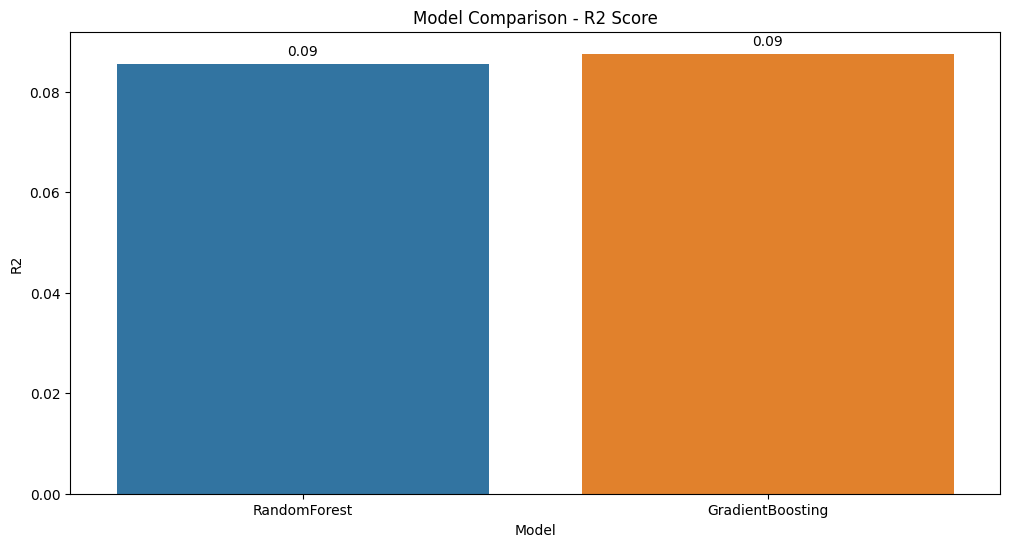

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from pyspark.sql import SparkSession
from pyspark.sql.functions import hour, dayofmonth, dayofweek, month, year, when, col

# Start Spark session
spark = SparkSession.builder.appName("Traffic Analysis").getOrCreate()

# Load the dataset with Spark
file_path = r'/content/sample_data/traffic.csv'
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Convert DateTime to datetime object and extract features with Spark
data = data.withColumn("hour", hour("DateTime"))
data = data.withColumn("day", dayofmonth("DateTime"))
data = data.withColumn("dayofweek", dayofweek("DateTime"))
data = data.withColumn("month", month("DateTime"))
data = data.withColumn("year", year("DateTime"))
data = data.withColumn("is_weekend", when(col("dayofweek") > 5, 1).otherwise(0))

# Convert Spark DataFrame to Pandas DataFrame for further processing
data_pd = data.toPandas()

# Drop the original DateTime column for model training
data_pd.drop(['DateTime'], axis=1, inplace=True)

# Check data types and adjust if necessary
print(data_pd.dtypes)

# Define features and target variable
X = data_pd.drop('Vehicles', axis=1)
y = data_pd['Vehicles']

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")

# Preprocessing Pipeline for Numeric and Categorical Data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# ColumnTransformer to apply transformations to the correct columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training and Evaluation
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)

# Pipeline with preprocessing and model
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', rf)])

gb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', gb)])

# Hyperparameter Tuning
rf_param_grid = {'model__n_estimators': [100, 150], 'model__max_depth': [10, 20]}
gb_param_grid = {'model__n_estimators': [100, 150], 'model__learning_rate': [0.1, 0.15]}

rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
gb_grid_search = GridSearchCV(gb_pipeline, gb_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit the grid search for RandomForest
print("Starting RandomForest GridSearchCV")
rf_grid_search.fit(X_train, y_train)
rf_best_model = rf_grid_search.best_estimator_
rf_best_pred = rf_best_model.predict(X_test)
rf_best_mse = mean_squared_error(y_test, rf_best_pred)
rf_best_r2 = r2_score(y_test, rf_best_pred)

# Fit the grid search for GradientBoosting
print("Starting GradientBoosting GridSearchCV")
gb_grid_search.fit(X_train, y_train)
gb_best_model = gb_grid_search.best_estimator_
gb_best_pred = gb_best_model.predict(X_test)
gb_best_mse = mean_squared_error(y_test, gb_best_pred)
gb_best_r2 = r2_score(y_test, gb_best_pred)

# Print out the best parameters and model evaluation results
print("RandomForest - Best MSE:", rf_best_mse, "Best R2:", rf_best_r2)
print("GradientBoosting - Best MSE:", gb_best_mse, "Best R2:", gb_best_r2)

# Visualization of Model Performance
plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True), label='Actual')
plt.plot(rf_best_pred, label='Predicted - RandomForest', alpha=0.7)
plt.plot(gb_best_pred, label='Predicted - GradientBoosting', alpha=0.7)
plt.title('Actual vs Predicted Traffic - Line Plot')
plt.legend()
plt.text(10, 30, f"RF MSE: {rf_best_mse:.2f}, R2: {rf_best_r2:.2f}", fontsize=9)
plt.text(10, 28, f"GB MSE: {gb_best_mse:.2f}, R2: {gb_best_r2:.2f}", fontsize=9)
plt.show()

# Error Distribution
plt.figure(figsize=(12, 6))
sns.histplot(y_test - rf_best_pred, bins=30, kde=True, label='RandomForest')
sns.histplot(y_test - gb_best_pred, bins=30, kde=True, color='orange', label='GradientBoosting')
plt.title('Error Distribution of Models')
plt.legend()
plt.text(0.5, 10, f"RF Error Mean: {(y_test - rf_best_pred).mean():.2f}", fontsize=9)
plt.text(0.5, 9, f"GB Error Mean: {(y_test - gb_best_pred).mean():.2f}", fontsize=9)
plt.show()

# Model Performance Metrics Visualization
metrics = pd.DataFrame({
    'Model': ['RandomForest', 'GradientBoosting'],
    'MSE': [rf_best_mse, gb_best_mse],
    'R2': [rf_best_r2, gb_best_r2]
})
plt.figure(figsize=(12, 6))
mse_plot = sns.barplot(x='Model', y='MSE', data=metrics)
plt.title('Model Comparison - Mean Squared Error')
for p in mse_plot.patches:
    mse_plot.annotate(format(p.get_height(), '.2f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'center',
                      xytext = (0, 9),
                      textcoords = 'offset points')
plt.show()

plt.figure(figsize=(12, 6))
r2_plot = sns.barplot(x='Model', y='R2', data=metrics)
plt.title('Model Comparison - R2 Score')
for p in r2_plot.patches:
    r2_plot.annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')
plt.show()
